In [1]:
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
def preprocess_text_with_line_numbers(text_lines: list):
    abstracts = {}
    for input_line in text_lines:
        input_line = input_line.strip().lower()
        if input_line.startswith("###"):
            abstract_id = input_line.strip("#")
            abstracts[abstract_id] = []
            continue
        if not input_line:
            continue
        abstracts[abstract_id].append(input_line)
    abstract_samples = []
    for abstract in abstracts:
        total_lines = len(abstracts[abstract]) -1
        for line_num, line in enumerate(abstracts[abstract]):
            line = line.strip()
            caption, text = line.split('\t')
            sample = {}
            sample["abstract_id"] = abstract
            sample["target"] = caption
            sample["text"] = text
            sample["line_number"] = line_num
            sample["total_lines"] = total_lines
            abstract_samples.append(sample)
    return abstract_samples       

In [3]:
def create_tensorboard_callback(experiment_name, model_name):
    """
    Create an tensorboard callback.
    """
    return tf.keras.callbacks.TensorBoard(log_dir=os.path.join("model_logs", experiment_name, model_name))

In [4]:
def create_model_checkpoint_callback(experiment_name, model_name):
    """
     Create an Model Checkpoint callback
    """
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join("model_checkpoints", experiment_name, model_name+".ckpt"),
                                              save_weights_only=True, monitor="val_acc", 
                                              save_best_only=True)

In [5]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-815dd684-e219-0fdd-061d-cf65e500b74c)


In [6]:
# Dataset source
DATASET_SOURCE = "../datasets/pubmed/pubmed-rct"
pubmed_20k_dataset = os.path.join(DATASET_SOURCE, "PubMed_20k_RCT_numbers_replaced_with_at_sign")
train_file = os.path.join(pubmed_20k_dataset, "train.txt")
test_file = os.path.join(pubmed_20k_dataset, "test.txt")
dev_file = os.path.join(pubmed_20k_dataset, "dev.txt")

In [7]:
with open(train_file, "r") as rfile:
    train_lines = rfile.readlines()
with open(test_file, "r") as rfile:
    test_lines = rfile.readlines()
with open(dev_file, "r") as rfile:
    dev_lines = rfile.readlines()

In [8]:
len(train_lines), len(test_lines)

(210040, 35135)

In [9]:
train_lines[0:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
train_abstracts = preprocess_text_with_line_numbers(train_lines)
test_abstracts = preprocess_text_with_line_numbers(test_lines)
dev_abstracts = preprocess_text_with_line_numbers(dev_lines)

In [11]:
len(train_abstracts), len(test_abstracts), len(dev_abstracts)

(180040, 30135, 30212)

In [12]:
train_df = pd.DataFrame(train_abstracts)
test_df = pd.DataFrame(test_abstracts)
val_df = pd.DataFrame(dev_abstracts)

In [13]:
print(train_df.head(), test_df.head(), val_df.head())

  abstract_id     target                                               text  \
0    24293578  objective  to investigate the efficacy of @ weeks of dail...   
1    24293578    methods  a total of @ patients with primary knee oa wer...   
2    24293578    methods  outcome measures included pain reduction and i...   
3    24293578    methods  pain was assessed using the visual analog pain...   
4    24293578    methods  secondary outcome measures included the wester...   

   line_number  total_lines  
0            0           11  
1            1           11  
2            2           11  
3            3           11  
4            4           11     abstract_id      target                                               text  \
0    24845963  background  this study analyzed liver function abnormaliti...   
1    24845963     results  a post hoc analysis was conducted with the use...   
2    24845963     results  liver function tests ( lfts ) were measured at...   
3    24845963     results

In [14]:
train_df.target.value_counts()

methods        59353
results        57953
conclusions    27168
background     21727
objective      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

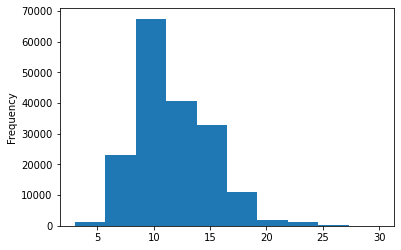

In [15]:
train_df.total_lines.plot.hist()

In [16]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
print(len(train_sentences), len(val_sentences), len(test_sentences))

train_labels = train_df["target"].to_list()
val_labels = val_df["target"].to_list()
test_labels = test_df["target"].to_list()
print(len(train_labels), len(val_labels), len(test_labels))


180040 30212 30135
180040 30212 30135


In [17]:
train_labels[:10]

['objective',
 'methods',
 'methods',
 'methods',
 'methods',
 'methods',
 'results',
 'results',
 'results',
 'results']

In [18]:
# one hot
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(np.array(train_labels).reshape(-1,1))
train_labels_one_hot = one_hot_encoder.transform(np.array(train_labels).reshape(-1,1))
val_labels_one_hot   = one_hot_encoder.transform(np.array(val_labels).reshape(-1,1))
test_labels_one_hot  = one_hot_encoder.transform(np.array(test_labels).reshape(-1,1))
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(train_labels))
train_labels_encoded = label_encoder.transform(np.array(train_labels))
val_labels_encoded = label_encoder.transform(np.array(val_labels))
test_labels_encoded = label_encoder.transform(np.array(test_labels))
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
label_encoder.classes_[4]

'results'

### Base Model

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
    ])
model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
base_preds = model_0.predict(test_sentences)
base_preds

array([2, 2, 2, ..., 4, 4, 4])

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results_score(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)*100
    print(f"[calculate_results_score] the accuracy is :: {model_accuracy}")
    model_precision, model_recall, model_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    print(f"[calculate_results_score] The precision is : {model_precision}")
    print(f"[calculate_results_score] The recall is : {model_recall}")
    print(f"[calculate_results_score] The f1 score is : {model_f1_score}")
    return {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1_score": model_f1_score,
             }

In [25]:
base_results = calculate_results_score(test_labels_encoded, base_preds)
base_results

[calculate_results_score] the accuracy is :: 71.6674962667994
[calculate_results_score] The precision is : 0.7124322482375202
[calculate_results_score] The recall is : 0.716674962667994
[calculate_results_score] The f1 score is : 0.6925101703856846


{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1_score': 0.6925101703856846}

## Deep model

In [26]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
average_sentence_length = sum(sentence_lengths)/len(train_sentences)
average_sentence_length

26.338269273494777

In [27]:
# average length of the sentences
np.mean(sentence_lengths)

26.338269273494777

In [28]:
# 95 % are under the 55 length
np.percentile(sentence_lengths, 95)

55.0

In [29]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=68000,
                                                    # Default
                                                    # standardize="lower_and_strip_punctuation",
                                                    # output_mode="int",
                                                    output_sequence_length=55)

2022-01-28 09:27:35.950148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 09:27:35.963896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 09:27:35.964478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 09:27:35.965141: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [30]:
text_vectorizer.adapt(train_sentences)

In [31]:
text_vectorizer.vocabulary_size()

64841

In [32]:
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'of']

In [33]:
embedding = tf.keras.layers.Embedding(input_dim=text_vectorizer.vocabulary_size(),
                                            output_dim=128,
                                            mask_zero=True,
                                            name="token_embedding",
                                       )

In [34]:
embedded_sentence = embedding(text_vectorizer(["The purpose of this experiment is to check if the paitent has covid19"]))
embedded_sentence.shape

TensorShape([1, 55, 128])

In [35]:
# dataset pipeline
train_dataset= tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

Model: "conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 convolution_layer (Conv1D)  (None, 55, 128)           82048     
                                                                 
 pooling_layer (GlobalAverag  (None, 128)              0         
 ePooling1D)                                                     
                                                                 
 output_layer (Dense)        (None, 5)                 6

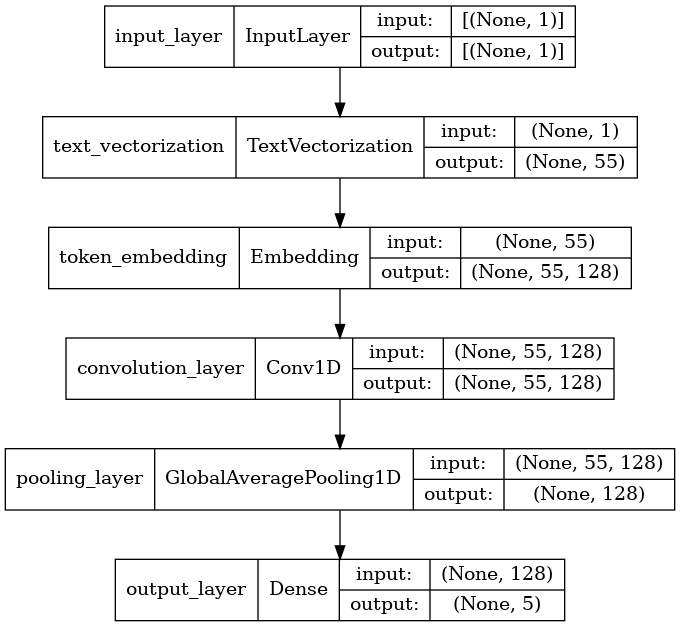

In [36]:
inputs_1 = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
vectorization_layer = text_vectorizer(inputs_1)
embedding_layer = embedding(vectorization_layer)
conv_layer = tf.keras.layers.Conv1D(filters=128,
                                    padding="same",
                                    activation="relu",
                                    kernel_size=5,
                                    name="convolution_layer")(embedding_layer)
pooling_layer = tf.keras.layers.GlobalAveragePooling1D(name="pooling_layer")(conv_layer)
outputs_1 = tf.keras.layers.Dense(units=5, activation="softmax", name="output_layer")(pooling_layer)
model_1 = tf.keras.Model(inputs=inputs_1, outputs=outputs_1, name="conv_model")
model_1.summary()
tf.keras.utils.plot_model(model=model_1, show_shapes=True)

In [37]:
# compile
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [38]:
# fit
model_1_history = model_1.fit(train_dataset,
                              
                                validation_data=valid_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_steps=int(0.1*len(valid_dataset)),
                                epochs=5,
                                callbacks=[create_model_checkpoint_callback("skimlit", model_1.name),
                                          create_tensorboard_callback("skimlit", model_1.name)]
            )

Epoch 1/5


2022-01-28 09:03:51.632612: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


562/562 [==============================] - 13s 18ms/step - loss: 0.8832 - accuracy: 0.6518 - val_loss: 0.6754 - val_accuracy: 0.7443
Epoch 2/5
562/562 [==============================] - 10s 18ms/step - loss: 0.6520 - accuracy: 0.7592 - val_loss: 0.6250 - val_accuracy: 0.7706
Epoch 3/5
562/562 [==============================] - 10s 17ms/step - loss: 0.6154 - accuracy: 0.7756 - val_loss: 0.5922 - val_accuracy: 0.7842
Epoch 4/5
562/562 [==============================] - 10s 17ms/step - loss: 0.5852 - accuracy: 0.7900 - val_loss: 0.5737 - val_accuracy: 0.7916
Epoch 5/5
562/562 [==============================] - 10s 17ms/step - loss: 0.5857 - accuracy: 0.7922 - val_loss: 0.5559 - val_accuracy: 0.7985


In [43]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5556 - accuracy: 0.8026


[0.5556045174598694, 0.8025950193405151]

In [44]:
model_1_pred_probs = model_1.predict(test_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([2, 2, 2, ..., 4, 4, 1])>

In [45]:
model_1_results = calculate_results_score(test_labels_encoded, model_1_preds)
model_1_results

[calculate_results_score] the accuracy is :: 79.6382943421271
[calculate_results_score] The precision is : 0.79604050665938
[calculate_results_score] The recall is : 0.7963829434212709
[calculate_results_score] The f1 score is : 0.793030269258065


{'accuracy': 79.6382943421271,
 'precision': 0.79604050665938,
 'recall': 0.7963829434212709,
 'f1_score': 0.793030269258065}

In [46]:
base_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1_score': 0.6925101703856846}

Model: "pretrained_embedding_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 fully_connected_layer_a (De  (None, 128)              65664     
 nse)                                                            
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


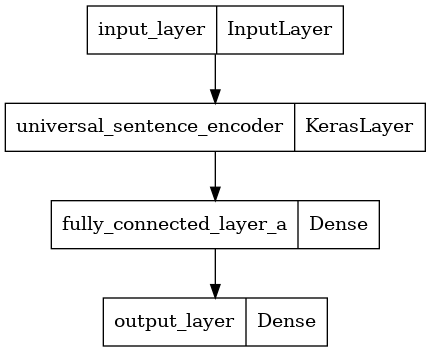

In [38]:
# tf hub pre trained model
inputs_2 = tf.keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")
encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                  trainable=False,
                                  name="universal_sentence_encoder")
embedding_layer = encoder_layer(inputs_2)
fully_connected_layer_a = tf.keras.layers.Dense(units=128, activation="relu", name="fully_connected_layer_a")(embedding_layer)
outputs_2 = tf.keras.layers.Dense(units=5, activation="softmax", name="output_layer")(fully_connected_layer_a)
model_2 = tf.keras.Model(inputs=inputs_2, outputs=outputs_2, name="pretrained_embedding_layer")
model_2.summary()
tf.keras.utils.plot_model(model_2)

In [39]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
model_2_history = model_2.fit(train_dataset,
            validation_data=valid_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_steps=int(0.1*len(valid_dataset)),
            epochs=5,
            callbacks=[create_model_checkpoint_callback("skimlit", model_2.name ),
                       create_tensorboard_callback("skimlit", model_2.name)]
            )

Epoch 1/5
559/562 [============================>.] - ETA: 0s - loss: 0.9168 - accuracy: 0.6518WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 14s 20ms/step - loss: 0.9161 - accuracy: 0.6520 - val_loss: 0.7974 - val_accuracy: 0.6862
Epoch 2/5
562/562 [==============================] - ETA: 0s - loss: 0.7706 - accuracy: 0.6996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 11s 20ms/step - loss: 0.7706 - accuracy: 0.6996 - val_loss: 0.7578 - val_accuracy: 0.7038
Epoch 3/5
561/562 [============================>.] - ETA: 0s - loss: 0.7553 - accuracy: 0.7103WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 11s 20ms/step - loss: 0.7552 - accuracy: 0.7104 - val_loss: 0.7413 - val_accuracy: 0.7084
Epoch 4/5
560/562 [============================>.] - ETA: 0s - loss: 0.7201 - accuracy: 0.7241WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 11s 20ms/step - loss: 0.7203 - accuracy: 0.7239 - val_loss: 0.7136 - val_accuracy: 0.7350
Epoch 5/5
561/562 [============================>.] - ETA: 0s - loss: 0.7287 - accuracy: 0.7198WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 11s 20ms/step - loss: 0.7285 - accuracy: 0.7199 - val_loss: 0.6925 - val_accuracy: 0.7370


In [50]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.6992 - accuracy: 0.7343


[0.6991832852363586, 0.7343108654022217]

In [51]:
model_2_pred_probs = model_2.predict(test_dataset)
model_2_pred_probs

array([[3.41071337e-01, 1.30332112e-01, 1.93242729e-01, 2.71525592e-01,
        6.38282150e-02],
       [3.62020791e-01, 2.86521800e-02, 2.26776943e-01, 3.57036769e-01,
        2.55132671e-02],
       [4.86393139e-04, 3.86733329e-03, 9.27258074e-01, 5.74279868e-04,
        6.78139329e-02],
       ...,
       [2.35546249e-04, 1.57161560e-02, 1.03412345e-02, 5.36898442e-05,
        9.73653376e-01],
       [5.37969870e-03, 4.07047421e-02, 5.83796576e-02, 1.54353655e-03,
        8.93992305e-01],
       [1.28374202e-02, 3.69985700e-01, 3.35097909e-01, 8.26486479e-03,
        2.73814112e-01]], dtype=float32)

In [52]:
model_2_results = calculate_results_score(test_labels_encoded, tf.argmax(model_2_pred_probs, axis=1))
model_2_results

[calculate_results_score] the accuracy is :: 72.73933963829434
[calculate_results_score] The precision is : 0.7239077425739536
[calculate_results_score] The recall is : 0.7273933963829434
[calculate_results_score] The f1 score is : 0.7222137766217608


{'accuracy': 72.73933963829434,
 'precision': 0.7239077425739536,
 'recall': 0.7273933963829434,
 'f1_score': 0.7222137766217608}

In [53]:
model_1_results

{'accuracy': 79.6382943421271,
 'precision': 0.79604050665938,
 'recall': 0.7963829434212709,
 'f1_score': 0.793030269258065}

In [54]:
base_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1_score': 0.6925101703856846}

### Character level encoding model

In [40]:
def split_chars(text):    
    return " ".join(list(text))

In [41]:
train_chars  = [split_chars(text) for text in train_sentences]
valid_chars  = [split_chars(text) for text in val_sentences]
test_chars  = [split_chars(text) for text in test_sentences]
train_chars[:1]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .']

In [42]:
np.mean([len(sentence) for sentence in train_sentences])

149.3662574983337

In [43]:
np.mean([len(sentence) for sentence in train_sentences])

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

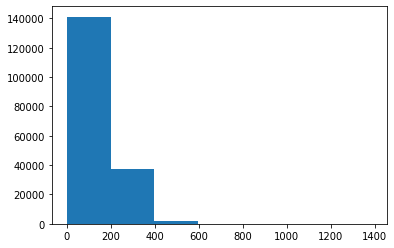

In [44]:
plt.hist([len(sentence) for sentence in train_sentences], bins=7)

In [45]:
np.percentile([len(sentence) for sentence in train_sentences], 95)

290.0

In [46]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [47]:
NUM_CHAR_TOKENS = len(alphabet) + 2
NUM_CHAR_TOKENS

70

In [48]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    output_sequence_length=290,
                                                    name="character_vectorizer")
char_vectorizer.adapt(train_chars)

In [49]:
char_vectorizer.get_config()

{'name': 'character_vectorizer',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 70,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 290,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [50]:
char_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'e', 't', 'i']

In [51]:
char_vectorizer.vocabulary_size()

28

In [52]:
char_embed = tf.keras.layers.Embedding(input_dim=char_vectorizer.vocabulary_size(),
                                       output_dim=25,
                                       mask_zero=True,
                                       name="char_embed")
char_embed

In [53]:
char_embed(char_vectorizer(["This is a text"]))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 0.0445802 , -0.0486031 ,  0.03042425, ...,  0.03379646,
         -0.00765437, -0.04994478],
        [ 0.0445802 , -0.0486031 ,  0.03042425, ...,  0.03379646,
         -0.00765437, -0.04994478],
        [-0.03376848,  0.01188866, -0.03443843, ...,  0.0236714 ,
         -0.02456341, -0.02533828],
        ...,
        [ 0.01714024,  0.03490695, -0.01438717, ..., -0.03081006,
         -0.0099931 ,  0.00646704],
        [ 0.01714024,  0.03490695, -0.01438717, ..., -0.03081006,
         -0.0099931 ,  0.00646704],
        [ 0.01714024,  0.03490695, -0.01438717, ..., -0.03081006,
         -0.0099931 ,  0.00646704]]], dtype=float32)>

Model: "char_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 char_embed (Embedding)      (None, 55, 25)            700       
                                                                 
 convolution_layer (Conv1D)  (None, 55, 64)            8064      
                                                                 
 pooling_layer (GlobalMaxPoo  (None, 64)               0         
 ling1D)                                                         
                                                                 
 output_layer (Dense)        (None, 5)        

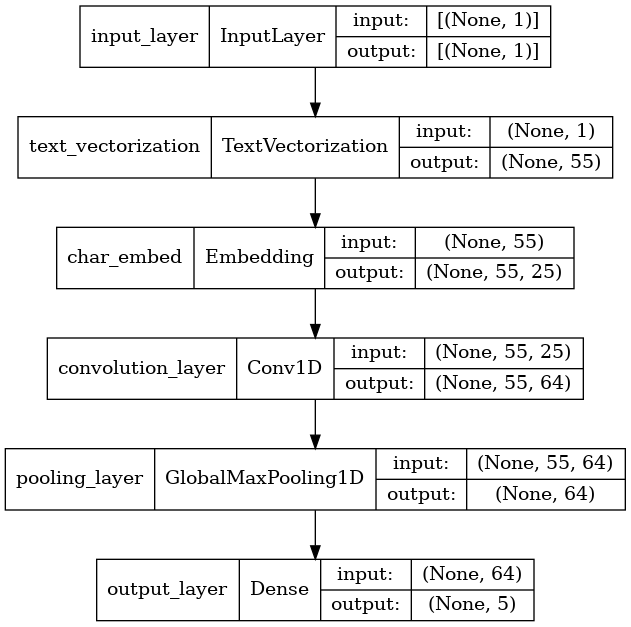

In [54]:
inputs_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
vectorization_layer = text_vectorizer(inputs_3)
embedding_layer = char_embed(vectorization_layer)
convolution_layer = tf.keras.layers.Conv1D(filters=64,
                                           kernel_size=5,
                                           padding="same",
                                           activation="relu",
                                           name="convolution_layer")(embedding_layer)
pooling_layer = tf.keras.layers.GlobalMaxPool1D(name="pooling_layer")(convolution_layer)
outputs_3 = tf.keras.layers.Dense(units=5,
                                  activation="relu",
                                  name="output_layer")(pooling_layer)
model_3 = tf.keras.Model(inputs=inputs_3, outputs=outputs_3, name="char_embedding_model")
model_3.summary()
tf.keras.utils.plot_model(model=model_3, show_shapes=True)

In [55]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
# dataset pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
history_model_3 = model_3.fit(train_dataset,
                        validation_data=valid_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_steps=int(0.1*len(valid_dataset)),
                        epochs=5,
                        callbacks=[create_model_checkpoint_callback("skimlit", model_3.name),
                                   create_tensorboard_callback("skimlit", model_3.name)])

Epoch 1/5
556/562 [============================>.] - ETA: 0s - loss: 10.7397 - accuracy: 0.2098WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 6s 9ms/step - loss: 10.7069 - accuracy: 0.2111 - val_loss: 7.7126 - val_accuracy: 0.3205
Epoch 2/5
556/562 [============================>.] - ETA: 0s - loss: 7.7484 - accuracy: 0.3260WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 5s 9ms/step - loss: 7.7491 - accuracy: 0.3260 - val_loss: 7.6986 - val_accuracy: 0.3205
Epoch 3/5
560/562 [============================>.] - ETA: 0s - loss: 7.8132 - accuracy: 0.3164WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 5s 9ms/step - loss: 7.8108 - accuracy: 0.3163 - val_loss: 7.6932 - val_accuracy: 0.3205
Epoch 4/5
562/562 [==============================] - ETA: 0s - loss: 7.7065 - accuracy: 0.3288WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 5s 9ms/step - loss: 7.7065 - accuracy: 0.3288 - val_loss: 7.6974 - val_accuracy: 0.3211
Epoch 5/5
556/562 [============================>.] - ETA: 0s - loss: 7.6663 - accuracy: 0.3276WARNING:tensorflow:Can save best model only with val_acc available, skipping.


562/562 [==============================] - 5s 9ms/step - loss: 7.6841 - accuracy: 0.3268 - val_loss: 7.6953 - val_accuracy: 0.3221


In [73]:
model_3.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 7.6667 - accuracy: 0.3262


[7.6667399406433105, 0.32616180181503296]

In [74]:
model_3_preds_probs = model_3.predict(test_dataset)
model_3_preds_probs

array([[0.        , 0.36148253, 0.        , 0.17683725, 0.7994141 ],
       [0.        , 0.5866841 , 0.        , 0.24236043, 0.80898553],
       [0.        , 0.38279024, 0.        , 0.20866288, 0.73055   ],
       ...,
       [0.        , 0.43130714, 0.        , 0.36384144, 0.80495054],
       [0.        , 0.3508219 , 0.        , 0.12320248, 0.83107626],
       [0.        , 0.43197986, 0.        , 0.21724926, 0.7436036 ]],
      dtype=float32)

In [75]:
model_3_results = calculate_results_score(test_labels_encoded,
                                          tf.argmax(model_3_preds_probs, axis=1))

[calculate_results_score] the accuracy is :: 32.25817156130745
[calculate_results_score] The precision is : 0.15300183588446734
[calculate_results_score] The recall is : 0.32258171561307447
[calculate_results_score] The f1 score is : 0.1592108622770655


/home/arun/learn/tensorflow_certification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Multi modal model, using multiple embedding layers, concatenate them

In [57]:
# model 4
# Token model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input")
# Vectorization + Embedding
# token_embeddings = hub.KerasLayer(hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
#                                   trainable=False,
#                                   name="universal_sentence_encoder"))
# embedding_layer = token_embeddings(token_inputs)
embedding_layer = encoder_layer(token_inputs)
token_output = tf.keras.layers.Dense(units=256, activation="relu", name="token_activation")(embedding_layer)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output, name="token_model")

# Character model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
# Vectorization
char_vectorization_layer = char_vectorizer(char_inputs)
# Embeddings
char_embeddings = tf.keras.layers.Embedding(input_dim=char_vectorizer.vocabulary_size(),
                                       output_dim=25,
                                       mask_zero=True,
                                       name="char_embed")
char_embedding_layer = char_embeddings(char_vectorization_layer)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=24, name="bidirectional_lstm"))(char_embedding_layer)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm, name="char_model")

# concatinate layer
token_char_concatinate = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                               char_model.output])
# Dropout layer
combined_dropout = tf.keras.layers.Dropout(rate=0.5, seed=273, name="combined_dropout_layer")(token_char_concatinate)
# Fully Connnected layer
combined_dense = tf.keras.layers.Dense(units=128, activation="relu", name="dense_layer_a")(combined_dropout)
# Secondary dropout layer
secondary_dropout = tf.keras.layers.Dropout(rate=0.5, seed=273)(combined_dense)
# output layer
output_layer = tf.keras.layers.Dense(units=5, activation="softmax", name="output_layer")(secondary_dropout)
# build model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                                outputs=output_layer,
                                name="token_and_character_model")


Model: "token_and_character_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

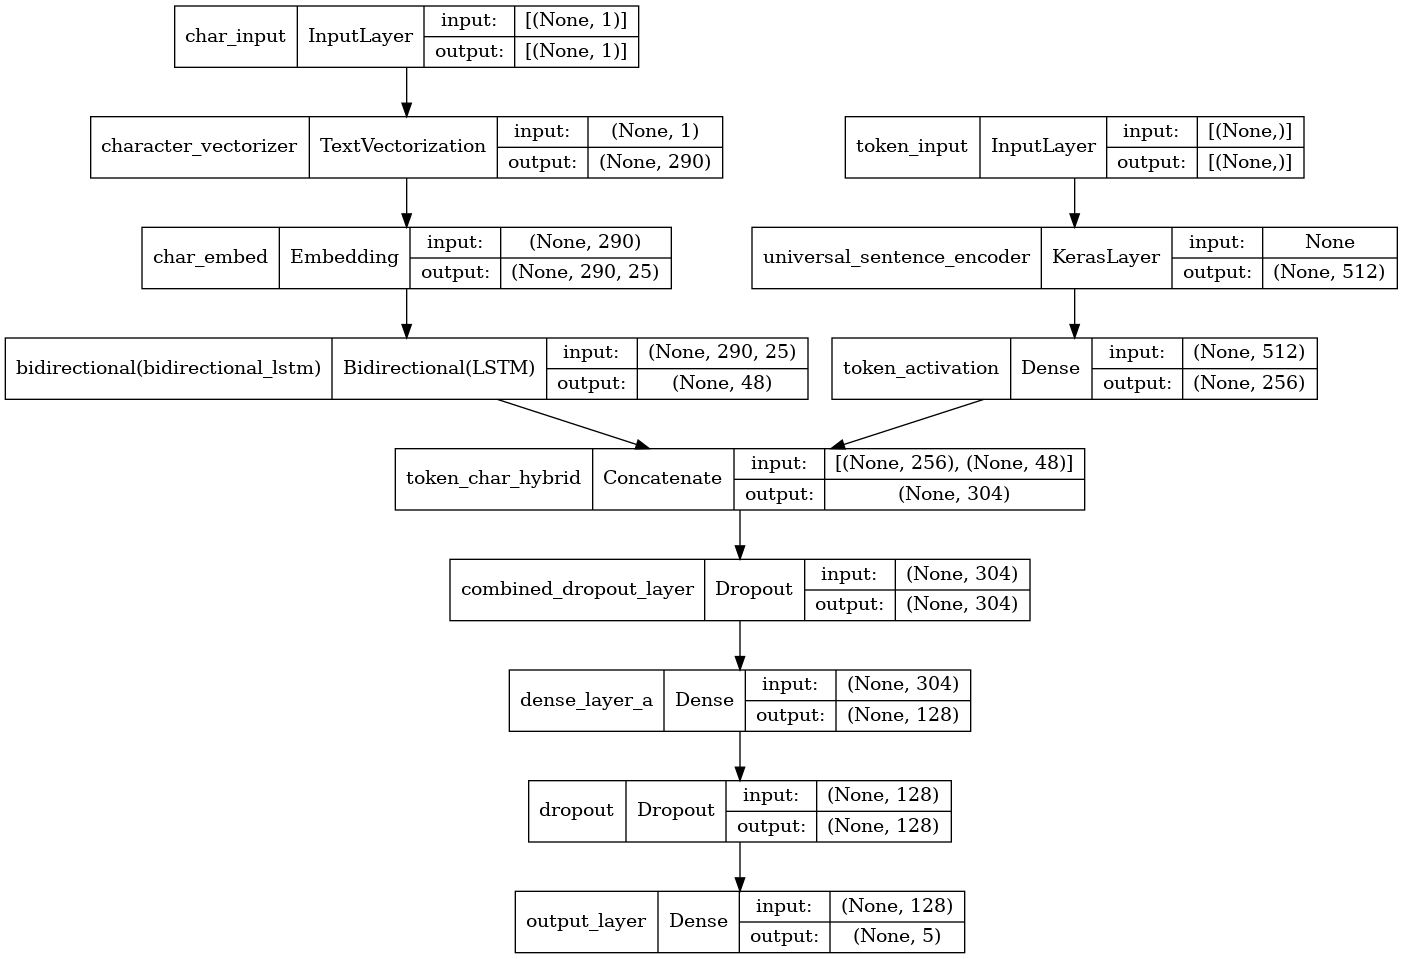

In [58]:
model_4.summary()
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [59]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
# dataset pipeline
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

valid_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, valid_chars))
valid_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
valid_char_token_dataset = tf.data.Dataset.zip((valid_char_token_data, valid_char_token_labels))

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_token_dataset = valid_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [63]:
model_4_history = model_4.fit(train_char_token_dataset,
                              validation_data=valid_char_token_dataset,
                              epochs=3,
                              callbacks=[create_model_checkpoint_callback("skimlit", model_4.name),
                                   create_tensorboard_callback("skimlit",model_4.name)])

Epoch 1/3


2022-01-28 09:30:13.343120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


5627/5627 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.7180WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 280s 48ms/step - loss: 0.7416 - accuracy: 0.7180 - val_loss: 0.6213 - val_accuracy: 0.7625
Epoch 2/3
5627/5627 [==============================] - ETA: 0s - loss: 0.6608 - accuracy: 0.7518WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 259s 46ms/step - loss: 0.6608 - accuracy: 0.7518 - val_loss: 0.5839 - val_accuracy: 0.7778
Epoch 3/3
5627/5627 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.7627WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 255s 45ms/step - loss: 0.6339 - accuracy: 0.7627 - val_loss: 0.5737 - val_accuracy: 0.7837


In [65]:
model_4.evaluate(valid_char_token_dataset)

945/945 [==============================] - 21s 23ms/step - loss: 0.5737 - accuracy: 0.7837


[0.573688268661499, 0.7836952209472656]

In [67]:
model_4_pred_probs = model_4.predict(test_char_token_dataset)
model_4_pred_probs[:10]

array([[2.6303184e-01, 1.7714673e-01, 1.6903979e-01, 2.3026849e-01,
        1.6051316e-01],
       [9.9251524e-02, 3.6532640e-02, 7.3681700e-01, 7.6145776e-02,
        5.1253047e-02],
       [8.1356935e-05, 9.2303625e-04, 9.3382376e-01, 1.0537068e-04,
        6.5066338e-02],
       [4.8708529e-03, 8.1098237e-04, 9.0040356e-01, 8.4236879e-03,
        8.5490942e-02],
       [8.2478678e-04, 6.9886535e-02, 3.0850049e-02, 2.7564366e-04,
        8.9816302e-01],
       [4.1366866e-06, 3.9671615e-04, 9.6908079e-05, 7.7568308e-07,
        9.9950147e-01],
       [5.6817154e-03, 1.7961744e-02, 3.6405611e-01, 4.2218575e-03,
        6.0807854e-01],
       [5.6994462e-01, 1.6749938e-01, 2.7010262e-02, 2.0574090e-01,
        2.9804841e-02],
       [8.5377924e-02, 5.2878821e-01, 3.2715868e-02, 2.2562692e-02,
        3.3055532e-01],
       [3.8958085e-01, 4.4888076e-01, 4.3405727e-03, 1.5187269e-01,
        5.3250776e-03]], dtype=float32)

In [68]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [69]:
model_4_results = calculate_results_score(test_labels_encoded,
                                         model_4_preds)

[calculate_results_score] the accuracy is :: 77.82312925170068
[calculate_results_score] The precision is : 0.7763376043833893
[calculate_results_score] The recall is : 0.7782312925170068
[calculate_results_score] The f1 score is : 0.7743845356333635


In [71]:
test_df.head(5)

,abstract_id,target,text,line_number,total_lines
0,24845963,background,this study analyzed liver function abnormaliti...,0,8
1,24845963,results,a post hoc analysis was conducted with the use...,1,8
2,24845963,results,liver function tests ( lfts ) were measured at...,2,8
3,24845963,results,survival analyses were used to assess the asso...,3,8
4,24845963,results,the percentage of patients with abnormal lfts ...,4,8


In [72]:
train_df.head(5)

,abstract_id,target,text,line_number,total_lines
0,24293578,objective,to investigate the efficacy of @ weeks of dail...,0,11
1,24293578,methods,a total of @ patients with primary knee oa wer...,1,11
2,24293578,methods,outcome measures included pain reduction and i...,2,11
3,24293578,methods,pain was assessed using the visual analog pain...,3,11
4,24293578,methods,secondary outcome measures included the wester...,4,11


In [73]:
tf.one_hot(train_df["line_number"].to_numpy(), depth=15)

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [77]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"], depth=16)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"], depth=16)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"], depth=16)

16.0

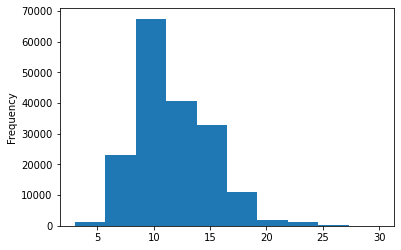

In [80]:
train_df["total_lines"].value_counts()
train_df["total_lines"].plot.hist()
np.percentile(train_df["total_lines"], 90)

In [81]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"], depth=16)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"], depth=16)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"], depth=16)

In [89]:
# Token+ Char + Positinal Embeddings


## Token Layer Model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input_layer")
token_embedding_layer = encoder_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(units=128,activation="relu", name="token_output_layer")(token_embedding_layer)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs, name="token_embedding_model")
# Char Layer Model
char_inputs =tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input_layer")
char_vectorization_layer = char_vectorizer(char_inputs)
char_embedding_layer = char_embeddings(char_vectorization_layer)
char_bi_lstm_layer = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(units=24, name="char_bi_direc_lstm_layer")
)(char_embedding_layer)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm_layer, name="char_embedding_model")

# Line Number layer 
line_inputs = tf.keras.layers.Input(shape=(16,), dtype=tf.float32, name="line_input_layer")
line_dense_layer = tf.keras.layers.Dense(units=128, activation="relu", name="line_dense_layer")(line_inputs)
line_model = tf.keras.Model(inputs=line_inputs, outputs=line_dense_layer, name="line_embedding_model")
# total lines layer
total_lines_input = tf.keras.layers.Input(shape=(16,), dtype=tf.float32, name="total_lines_input_layer")
total_lines_dense_layer = tf.keras.layers.Dense(units=128, activation="relu", name="total_lines_dense_layer")(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input, outputs=total_lines_dense_layer, name="total_lines_ebedding_model")


# Concatenate the token and char models
combined_embeddings = tf.keras.layers.Concatenate(name="token_char_concatenation_layer")([token_model.output,
                                                                                          char_model.output])
combined_dense_layer = tf.keras.layers.Dense(units=128, activation="relu", name="combined_dense_layer")(combined_embeddings)
combined_dropout_layer = tf.keras.layers.Dropout(rate=0.5, seed=273, name="combined_dropout_layer")(combined_dense_layer)

# join the conmbined model with the line and total line models
multi_embeddings = tf.keras.layers.Concatenate(name="multi_embedding_concatination_layer")([line_model.output,
                                                                                       total_lines_model.output,
                                                                                       combined_dropout_layer ])


# Output Layer
output_layer = tf.keras.layers.Dense(units=5, activation="softmax", name="output_layer")(multi_embeddings)

# Build Model
model_5 = tf.keras.Model(inputs=[tf.argmax(model_4_pred_probs, axis=1)
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer, 
                         name="token_char_positional_feature_model")


Model: "token_char_positional_feature_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input_layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_input_layer (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['char_input_layer[0][0]']       
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824  

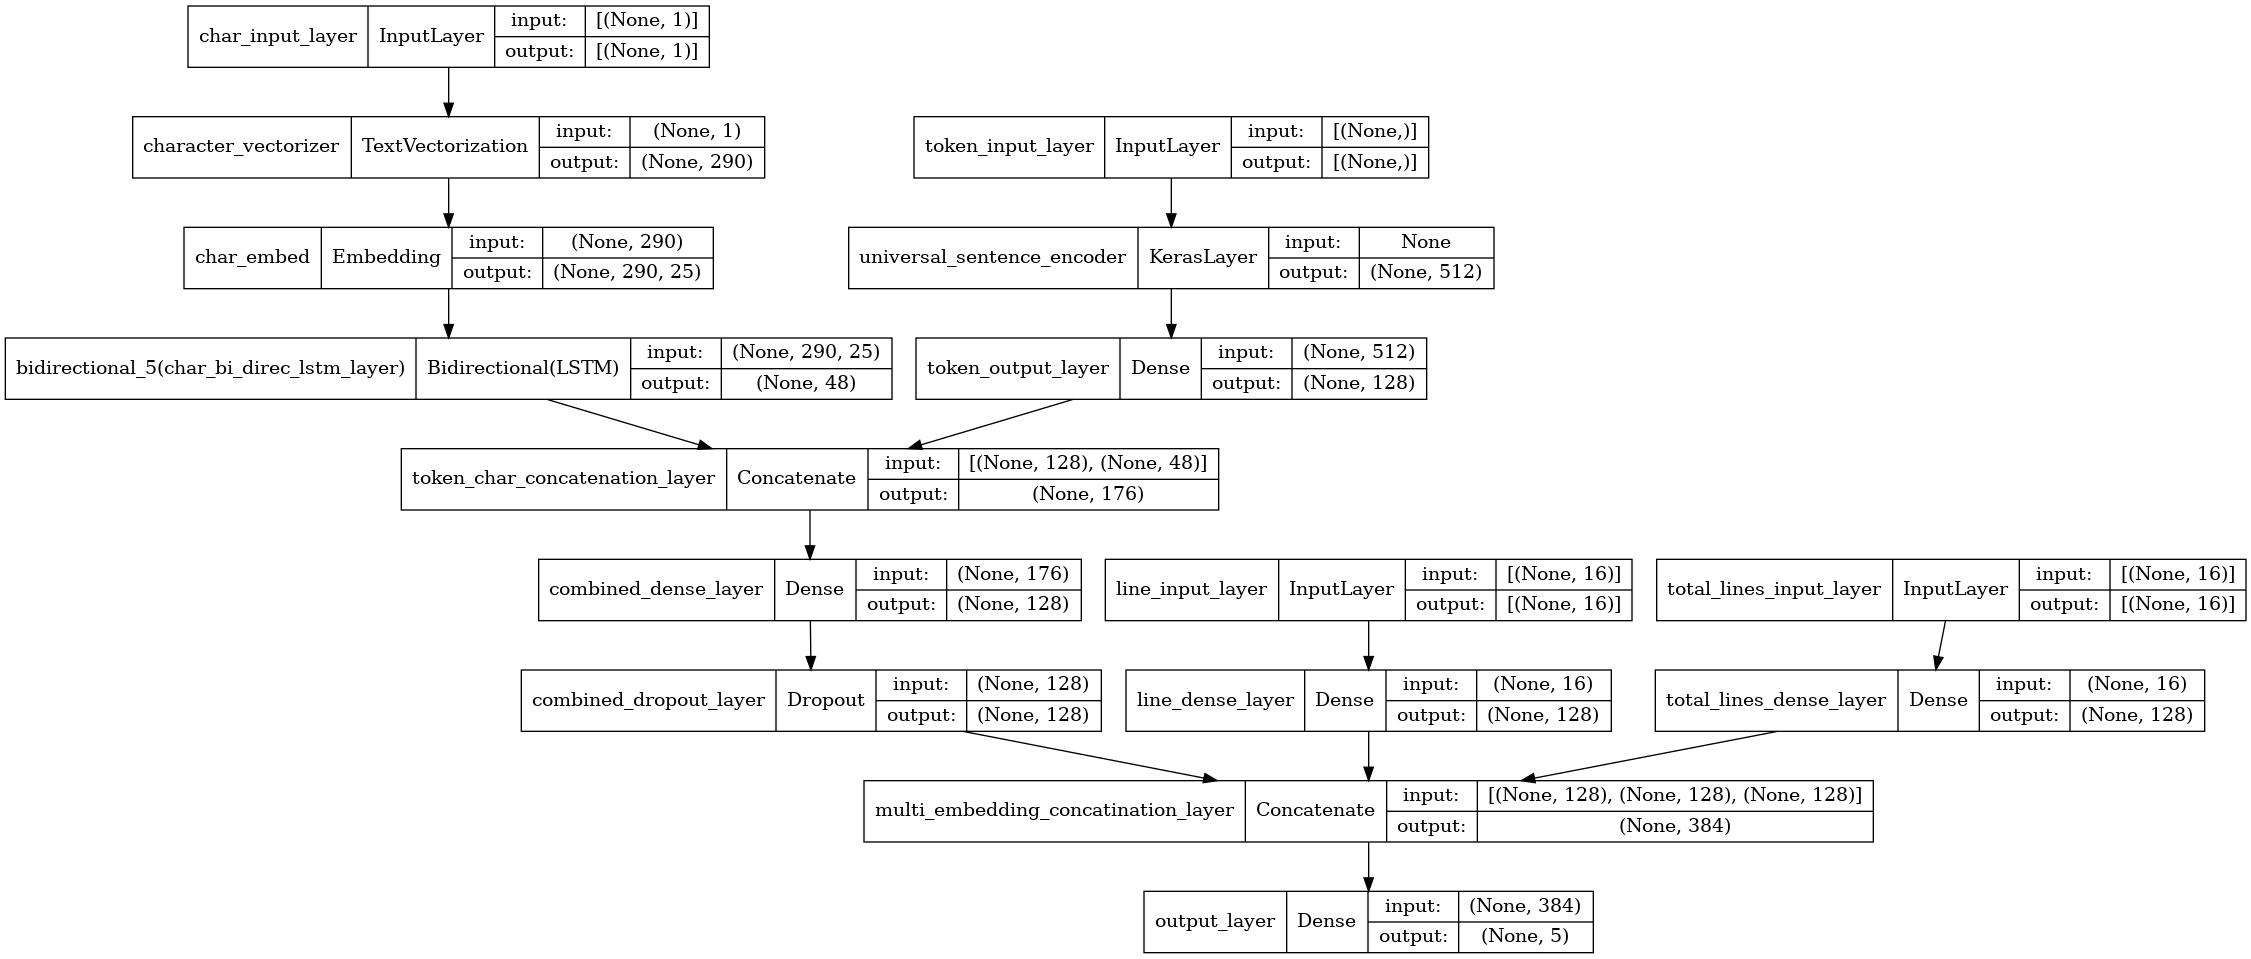

In [91]:
model_5.summary()
tf.keras.utils.plot_model(model=model_5, show_shapes=True)

In [92]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [96]:
train_positional_token_char_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                       train_total_lines_one_hot,
                                                                       train_sentences,
                                                                       train_chars))
train_positional_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_positional_token_char_dataset = tf.data.Dataset.zip((train_positional_token_char_data, train_positional_token_char_labels))
train_positional_token_char_dataset = train_positional_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



val_positional_token_char_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                       val_total_lines_one_hot,
                                                                       val_sentences,
                                                                       valid_chars))
val_positional_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_positional_token_char_dataset = tf.data.Dataset.zip((val_positional_token_char_data, val_positional_token_char_labels))
val_positional_token_char_dataset = val_positional_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_positional_token_char_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                       test_total_lines_one_hot,
                                                                       test_sentences,
                                                                       test_chars))
test_positional_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_positional_token_char_dataset = tf.data.Dataset.zip((test_positional_token_char_data, test_positional_token_char_labels))
test_positional_token_char_dataset = test_positional_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [97]:
model_5_history = model_5.fit(train_positional_token_char_dataset,
                              validation_data=val_positional_token_char_dataset, 
                              epochs=5,
                              callbacks=[
                                  create_model_checkpoint_callback("skimlit", model_5.name),
                                   create_tensorboard_callback("skimlit",model_5.name)
                              ])

Epoch 1/5
5626/5627 [============================>.] - ETA: 0s - loss: 0.9355 - accuracy: 0.8379WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 307s 54ms/step - loss: 0.9355 - accuracy: 0.8379 - val_loss: 0.9066 - val_accuracy: 0.8507
Epoch 2/5
5626/5627 [============================>.] - ETA: 0s - loss: 0.9121 - accuracy: 0.8544WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 298s 53ms/step - loss: 0.9121 - accuracy: 0.8544 - val_loss: 0.9003 - val_accuracy: 0.8540
Epoch 3/5
5627/5627 [==============================] - ETA: 0s - loss: 0.9012 - accuracy: 0.8620WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 287s 51ms/step - loss: 0.9012 - accuracy: 0.8620 - val_loss: 0.8980 - val_accuracy: 0.8548
Epoch 4/5
5627/5627 [==============================] - ETA: 0s - loss: 0.8932 - accuracy: 0.8676WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 273s 48ms/step - loss: 0.8932 - accuracy: 0.8676 - val_loss: 0.8954 - val_accuracy: 0.8571
Epoch 5/5
5627/5627 [==============================] - ETA: 0s - loss: 0.8868 - accuracy: 0.8727WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 282s 50ms/step - loss: 0.8868 - accuracy: 0.8727 - val_loss: 0.8970 - val_accuracy: 0.8559


In [98]:
model_5.evaluate(val_positional_token_char_dataset)

945/945 [==============================] - 24s 25ms/step - loss: 0.8970 - accuracy: 0.8559


[0.8969784379005432, 0.8559181690216064]

In [99]:
model_5_pred_probs = model_5.predict(test_positional_token_char_dataset)
model_5_pred_probs[:10]

array([[0.27560073, 0.08037592, 0.10280339, 0.36886907, 0.17235085],
       [0.20428249, 0.05846959, 0.45862058, 0.18901251, 0.08961481],
       [0.03995715, 0.02234693, 0.8605123 , 0.05095474, 0.0262288 ],
       [0.04438792, 0.05384193, 0.6822918 , 0.05910152, 0.16037683],
       [0.04264792, 0.04575336, 0.09183652, 0.04410852, 0.7756537 ],
       [0.03406746, 0.02625343, 0.02254152, 0.03624673, 0.8808909 ],
       [0.01296793, 0.05083843, 0.0642291 , 0.02436111, 0.8476035 ],
       [0.08598801, 0.6334446 , 0.06416637, 0.03789697, 0.178504  ],
       [0.02758859, 0.7493906 , 0.01168161, 0.02714928, 0.18418998],
       [0.6356627 , 0.02950053, 0.04145429, 0.26572242, 0.02765997]],
      dtype=float32)

In [102]:
model_5_results =  calculate_results_score(test_labels_encoded,
                                         tf.argmax(model_5_pred_probs, axis=1))

[calculate_results_score] the accuracy is :: 84.88136718101875
[calculate_results_score] The precision is : 0.8499090290624693
[calculate_results_score] The recall is : 0.8488136718101875
[calculate_results_score] The f1 score is : 0.845899156977442


In [103]:
model_5_results

{'accuracy': 84.88136718101875,
 'precision': 0.8499090290624693,
 'recall': 0.8488136718101875,
 'f1_score': 0.845899156977442}

In [ ]:
#